# Try this

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapz
from itertools import product

The spectrum that you modeled using Sherpa for lecture07_Model_Fitting was generated using a power law plus Lorentzian profile model as shown in the cell below.

Use these data to generate the probability distribution for the normalization of the background power law and the normalization of the emission line (i.e., flux), assuming we know all other parameters (as given in the equation below).  Visualize the distribution using a contour plot.

Then, marginalize over the normalization of the background power law to isolate the probability distribution of the emission line alone.  

Hints: 
 - First, what is the likelihood for these data?

### Answer:

The probability distribution is just the normalized likelihood $P({x_i}|A, B)$ for amplitude constants $A$ and $B$. This is because we assume a uniform prior. The likelihood at each point is distributed normally, or so I assume.

In [2]:
def lor_profile(wave, gamma, offset):
    f1 = gamma / np.pi
    f2 = (wave - offset)**2 + gamma**2
    return f1 / f2

def power_law(wave, scale, power):
    return (scale * wave)**power

# wave = np.linspace(5800., 6200., 401, endpoint=True)
gamma = 8.
offset = 6000.

# spectrum = 5. * power_law(wave, 1 / 6000., -1) + 200. * lor_profile(wave, gamma, offset)

# plt.plot(wave, mu)

Here I calculate the log-likelihood of all our data fitting the model with parameters $4 \leq A \leq 7$ and $190 \leq B \leq 210$. Then I exponentiate to get the probability function. Finally, I normalize the PDF.

The log-likelihood and PDF plots are given below. The 1, 2, and 3$\sigma$ contours are also displayed.

In [3]:
fn = '../tt7/test_spectrum.dat'
data = np.loadtxt(fn)

wave = data[:, 0]
flux = data[:, 1]
eflux = data[:, 2]

N = wave.shape[0]

lenA = 500
lenB = 500
A = np.linspace(4, 7, lenA)
B = np.linspace(190, 210, lenB)

def mu(A, B):
    return A * power_law(wave, 1 / 6000., -1) + B * lor_profile(wave, gamma, offset)

def gauss_logL(A, B):
    sum_terms = ((flux - mu(A, B)) / eflux)**2
    return -0.5 * np.sum(sum_terms)

logL = np.empty((lenA, lenB))

for i, j in product(range(lenA), range(lenB)):
    logL[i, j] = gauss_logL(A[i], B[j])

likelihood = np.exp(logL)
likelihood /= np.sum(likelihood) * (A[1] - A[0]) * (B[1] - B[0])

max_ind = np.unravel_index(np.argmax(logL), logL.shape)
A0 = A[max_ind[1]]
B0 = B[max_ind[0]]
print(f'A0 = {A0:.3f}, B0 = {B0:.3f}')

A0 = 5.996, B0 = 196.413


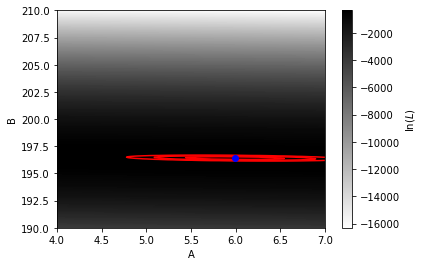

In [4]:
def convert_to_stdev(logL, log=True):
    """
    Given a grid of log-likelihood values, convert them to cumulative
    standard deviation.  This is useful for drawing contours from a
    grid of likelihoods.
    """
    if log:
        sigma = np.exp(logL)
    else:
        sigma = logL

    shape = sigma.shape
    sigma = sigma.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(sigma)[::-1]
    i_unsort = np.argsort(i_sort)

    sigma_cumsum = sigma[i_sort].cumsum()
    sigma_cumsum /= sigma_cumsum[-1]

    return sigma_cumsum[i_unsort].reshape(shape)

plt.imshow(logL, origin='lower',
           extent=(A[0], A[-1], B[0], B[-1]),
           cmap=plt.cm.binary,
           aspect='auto')
plt.colorbar().set_label(r'$\ln(L)$')
# plt.clim(-5, 0)

plt.plot(A0, B0, 'o', c='b', zorder=3)

plt.contour(A, B, convert_to_stdev(logL),
            levels=(0.683, 0.955, 0.997),
            colors='r', zorder=2)

plt.xlabel('A')
plt.ylabel('B')

plt.show()

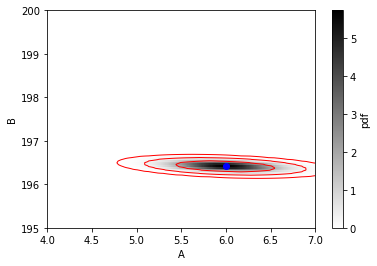

In [5]:
plt.imshow(likelihood, origin='lower',
           extent=(A[0], A[-1], B[0], B[-1]),
           cmap=plt.cm.binary,
           aspect='auto')
plt.colorbar().set_label('pdf')
# plt.clim(-5, 0)

plt.plot(A0, B0, 'o', c='b', zorder=3)

plt.contour(A, B, convert_to_stdev(likelihood, log=False),
            levels=(0.683, 0.955, 0.997), linewidths=1,
            colors='r', zorder=2)

plt.ylim(195, 200)

plt.xlabel('A')
plt.ylabel('B')

plt.show()

I finally marginalize across all values of $A$ to get a PDF for the $B$ parameter. The plot is again show below. I find an expected value of $B_0 \approx 196$.

expected B: 196.4128256513026


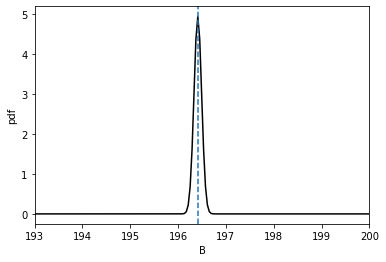

In [6]:
pdfB = trapz(likelihood, A)
pdfB /= trapz(pdfB, B)

B0 = B[np.argmax(pdfB)]
print(f'expected B: {B0}')

plt.plot(B, pdfB, c='k')
plt.axvline(B0, ls='--')

plt.xlim(193, 200)
plt.xlabel('B')
plt.ylabel('pdf')

plt.show()